# MAIA Demo

#### Many of MAIA's experiments are available in the [experiment browser](https://multimodal-interpretability.csail.mit.edu/maia/experiment-browser/) ####

In [23]:
import argparse
from getpass import getpass
import os
from tqdm import tqdm
import time
from random import random, uniform
import torch
import json
from call_agent import ask_agent
from IPython import embed
from maia_api import *
import random

### Load openai api key 

(in case you don't have an openai api-key, you can get one by following the instructions [here](https://platform.openai.com/docs/quickstart)).
\
\
option 1:
\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Set your api-key as an environment variable (this is a bash command, look [here](https://platform.openai.com/docs/quickstart) for other OS)
```bash
export OPENAI_API_KEY='your-api-key-here'
```
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Load your API key from an environment variable or secret management service
```python
openai.api_key = os.getenv("OPENAI_API_KEY")
```
option 2:
\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Load your API key manually:
```python
openai.api_key = 'your-api-key-here'
```


In [7]:
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.organization = os.getenv("OPENAI_ORGANIZATION")

In [30]:
model = 'resnet152' # we currently support 'resnet152', 'clip-RN50', 'dino_vits8' and "synthetic_neurons" (NEW!)
layer = 'layer4' # for "synthetic_neurons" this will be the operation mode: "mono", "or" or "and" (see paper for details)
unit = 122
setting = 'neuron_description'
maia_model = 'gpt-4-vision-preview'
path2prompts = './prompts/'
path2save = './results/'
path2exemplars = './exemplars/'
device_id = 0
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu") 
text2image = 'sd' # "sd" is for stable-diffusion

In [31]:
# return the prompt according to the task
def return_Prompt(prompt_path,setting='neuron_description'):
    with open(f'{prompt_path}/api.txt', 'r') as file:
        sysPrompt = file.read()
    with open(f'{prompt_path}/user_{setting}.txt', 'r') as file:
        user_prompt = file.read()
    return sysPrompt, user_prompt
    
maia_api, user_query = return_Prompt(path2prompts, setting) # load system prompt (maia api) and user prompt (the user query)

### MAIA API

In [32]:
print(maia_api)

import torch
from typing import List, Tuple

class System:
    """
    A Python class containing the vision model and the specific neuron to interact with.
    
    Attributes
    ----------
    neuron_num : int
        The unit number of the neuron.
    layer : string
        The name of the layer where the neuron is located.
    model_name : string
        The name of the vision model.
    model : nn.Module
        The loaded PyTorch model.

    Methods
    -------
    load_model(model_name: str) -> nn.Module
        Gets the model name and returns the vision model from PyTorch library.
    call_neuron(image_list: List[torch.Tensor]) -> Tuple[List[int], List[str]]
        returns the neuron activation for each image in the input image_list as well as the activation map 
        of the neuron over that image, that highlights the regions of the image where the activations 
        are higher (encoded into a Base64 string).
    """
    def __init__(self, neuron_num: int, layer: str, mod

### Interpretability task

In [33]:
print(user_query)

Your overall task is to describe the visual concepts that maximally activate a neuron inside a deep network for computer vision. 
To do that you are provided with a library of Python functions to run experiments on the specific neuron (inside the "System" class) given the functions provided in the "Tools" class. Make sure to use a variety of tools from the library to maximize your experimentation power.
Some neurons might be selective for very specific concepts, a group of unrelated concepts, or a general concept, so try to be creative in your experiment and try to test both general and specific concepts. If a neuron is selective for multiple concepts, you should describe each of those concepts in your final description. 
At each experiment step, write Python code that will conduct your experiment on the tested neuron, using the following format:
[CODE]: 
```python
def execute_command(system, tools)
    # gets an object of the system class, an object of the tool class, and performs exp

### Initializations

In [34]:
if model=="synthetic_neurons":
    net_dissect = SyntheticExemplars(os.path.join(path2exemplars, model), path2save, layer) # precomputes synthetic dataset examplars for tools.dataset_exemplars. 
    with open(os.path.join('./synthetic-neurons-dataset/labels/',f'{layer}.json'), 'r') as file: # load the synthetic neuron labels
        synthetic_neuron_data = json.load(file)
        gt_label = synthetic_neuron_data[unit]["label"].rsplit('_')
        print("groundtruth label:",gt_label)
        system = Synthetic_System(unit, gt_label, layer, device_id)
else:
    net_dissect = DatasetExemplars(path2exemplars, path2save, model, layer, [unit]) # precomputes dataset exemplars for tools.dataset_exemplars
    system = System(unit, layer, model, device_id, net_dissect.thresholds) # initialize the system class

tools = Tools(path2save, device_id, net_dissect, text2image_model_name=text2image, images_per_prompt=1) # initialize the tools class

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [35]:
tools.experiment_log = []
tools.update_experiment_log(role='system', type="text", type_content=maia_api) # update the experiment log with the system prompt
tools.update_experiment_log(role='user', type="text", type_content=user_query) # update the experiment log with the user prompt

### Utils

In [36]:
# Parse the code by locating Python syntax
def get_code(maia_experiment):
    maia_code = maia_experiment.split('```python')[1].split('```')[0]
    return maia_code

# Run the code on python
def execute_maia_experiment(code,system,tools): 
    exec(compile(code, 'code', 'exec'), globals())
    execute_command(system,tools)
    return  

# Plot the results from the experiment log
def plot_results_notebook(experiment_log):
    if (experiment_log['role'] == 'assistant'):
        print('\n\n*** MAIA: ***\n\n')  
    else: 
        print('\n\n*** Experiment Execution: ***\n\n')
    for item in experiment_log['content']:
        if item['type'] == 'text':
            print(item['text'])
        elif item['type'] == 'image_url':
            display(str2image(item['image_url']['url'].split(',')[1]))

### MAIA's interpretation experiment

Please note: 
This demo does not handle open-ai api exceptions and bugs in MAIA's code, please switch to ```main.py``` for error handling (recommended for looping over several units). ```main.py``` also handles saving results.



*** MAIA: ***


[CODE]: 
```python
def execute_command(system, tools):
    # Use the dataset exemplars to get general idea of what activates the neuron
    activation_list, image_list = tools.dataset_exemplars(system)
    tools.save_experiment_log(activation_list, image_list, [f"dataset_exemplar {i}" for i in range(len(activation_list))], None)
```

[HYPOTHESIS LIST]: 
Hypothesis_1: The neuron might be selective for specific types of animals.
Hypothesis_2: The neuron might be selective for particular environments or contexts where the subjects of the image are located (e.g., urban vs. natural environments).
Hypothesis_3: The neuron might be selective for certain colors or patterns present in the images.
Hypothesis_4: The neuron might be selective for specific actions performed by subjects within the images.


*** Experiment Execution: ***


Neuron activations:

"dataset_exemplar 0", activation: 36.92
image: 



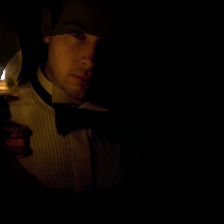

"dataset_exemplar 1", activation: 35.61
image: 



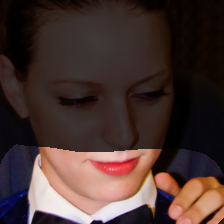

"dataset_exemplar 2", activation: 34.16
image: 



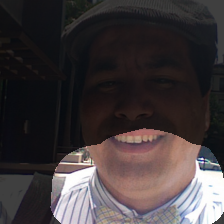

"dataset_exemplar 3", activation: 32.29
image: 



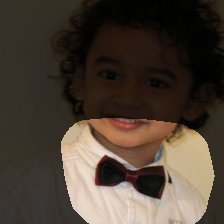

"dataset_exemplar 4", activation: 31.8
image: 



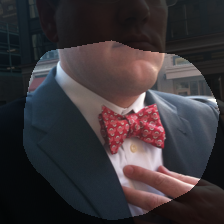

"dataset_exemplar 5", activation: 30.8
image: 



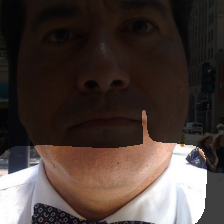

"dataset_exemplar 6", activation: 30.59
image: 



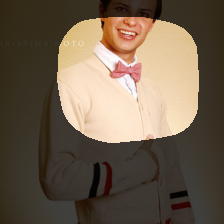

"dataset_exemplar 7", activation: 30.59
image: 



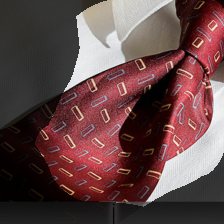

"dataset_exemplar 8", activation: 30.56
image: 



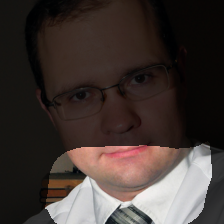

"dataset_exemplar 9", activation: 29.43
image: 



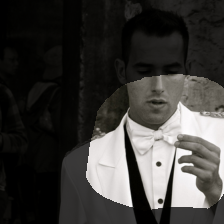

"dataset_exemplar 10", activation: 29.35
image: 



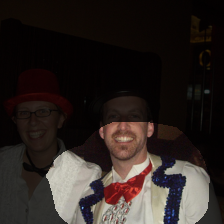

"dataset_exemplar 11", activation: 29.24
image: 



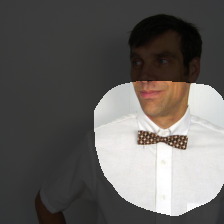

"dataset_exemplar 12", activation: 28.83
image: 



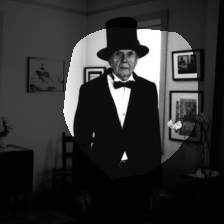

"dataset_exemplar 13", activation: 28.78
image: 



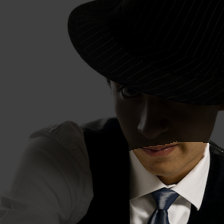

"dataset_exemplar 14", activation: 28.6
image: 



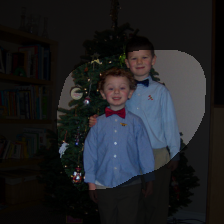



*** MAIA: ***


Based on the images provided and the highlighted regions that are activating the neuron, it appears that the common visual concept among these images involves facial features and attire, particularly bow ties and ties. Given this observation, let's update our hypotheses.

[HYPOTHESIS LIST]: 
Hypothesis_1: The neuron is selective for facial features of people.
Hypothesis_2: The neuron is selective for people wearing bow ties.
Hypothesis_3: The neuron is selective for formal attire, specifically neckwear such as ties and bow ties.

[CODE]: 
```python
def execute_command(system, tools):
    # Experiment 1: Test if the neuron is activated by facial features without formal attire
    prompts_faces = ["a person smiling", "a person frowning", "a person with blue eyes", "a person with glasses"]
    images_faces = tools.text2image(prompts_faces)
    
    # Experiment 2: Test if the neuron is activated by bow ties on subjects other than people
    prompts_bow_ties = ["a cat wea

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]



*** Experiment Execution: ***


Neuron activations:

"a person smiling", activation: 3.32
image: 



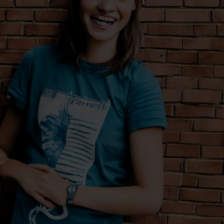

"a person frowning", activation: 15.83
image: 



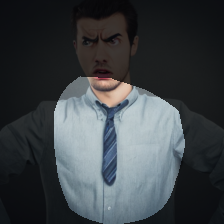

"a person with blue eyes", activation: 0.29
image: 



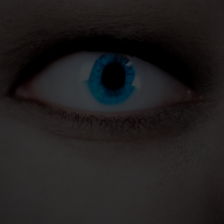

"a person with glasses", activation: 2.09
image: 



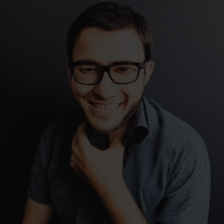

"a cat wearing a bow tie", activation: 21.19
image: 



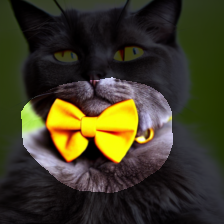

"a dog wearing a bow tie", activation: 26.73
image: 



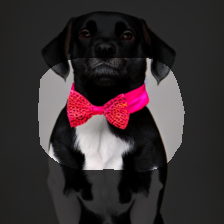

"a teddy bear wearing a bow tie", activation: 27.18
image: 



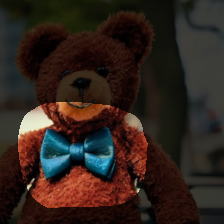

"a person wearing a suit without a tie", activation: 11.18
image: 



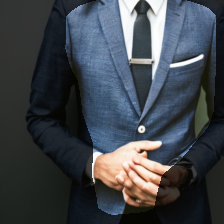

"a person wearing a business dress", activation: 9.18
image: 



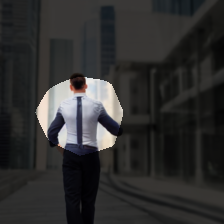


Max activation is smaller than 31.17, please continue with the experiments.



*** MAIA: ***


The activations suggest that the presence of a bow tie, regardless of whether it is worn by a human or an animal, causes a higher activation in the neuron than facial features alone or formal attire without a bow tie. This supports the hypothesis that the neuron is selective for bow ties. Based on these new results, let's update our hypotheses.

[HYPOTHESIS LIST]: 
Hypothesis_1: The neuron is selective for bow ties regardless of the wearer.
Hypothesis_2: The neuron is selectively responding to the combination of bow ties and facial features.

[CODE]: 
```python
def execute_command(system, tools):
    # Experiment 4: Test the neuron's activation to bow ties without faces
    prompts_bow_tie_no_face = ["a bow tie on a table", "a bow tie hanging on a hook"]
    images_bow_tie_no_face = tools.text2image(prompts_bow_tie_no_face)

    # Experiment 5: Test if changing the type of neckwear affects t

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]



*** Experiment Execution: ***


Neuron activations:

"a bow tie on a table", activation: 21.28
image: 



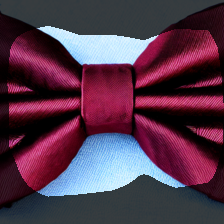

"a bow tie hanging on a hook", activation: 18.14
image: 



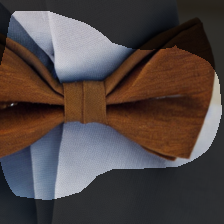

"a person wearing a scarf", activation: 3.79
image: 



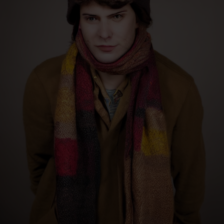

"a person wearing a cravat", activation: 13.59
image: 



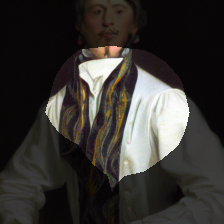

"a person wearing a bolo tie", activation: 14.21
image: 



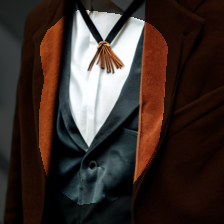


Max activation is smaller than 31.17, please continue with the experiments.



*** MAIA: ***


The neuron activations for images of bow ties, whether on a table or hanging on a hook, are significantly higher than the activations for other types of neckwear, such as scarves, cravats, and bolo ties. Importantly, these activations for bow ties are still below the threshold we saw in the dataset exemplars highlighting human features. We can conclude that bow ties are a key visual concept for this neuron, but the highest activations are achieved when a bow tie is associated with human facial features. Let's refine our hypotheses and conduct a further experiment to confirm this.

[HYPOTHESIS LIST]: 
Hypothesis_1: The neuron is strongly selective for bow ties when they are worn by subjects with facial features, particularly humans.

[CODE]: 
```python
def execute_command(system, tools):
    # Experiment 6: Test the neuron's activation to bow ties with variations in human facial features and 

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]



*** Experiment Execution: ***


Neuron activations:

"a person with a mustache wearing a bow tie", activation: 24.12
image: 



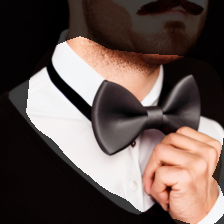

"a person with a beard wearing a bow tie", activation: 36.76
image: 



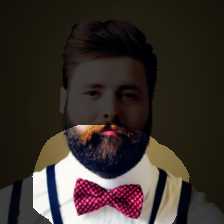

"a person with a bow tie in a professional headshot", activation: 29.5
image: 



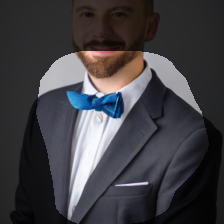

"a person with a bow tie in a casual setting", activation: 28.07
image: 



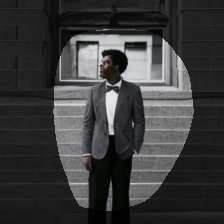

"a female person with a bow tie", activation: 33.63
image: 



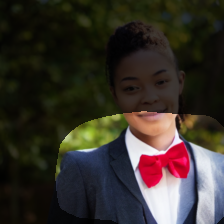

"a child wearing a bow tie", activation: 26.04
image: 



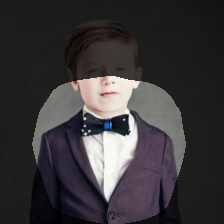

"a polka dot bow tie", activation: 27.69
image: 



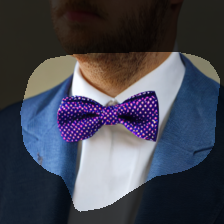

"a red bow tie", activation: 21.64
image: 



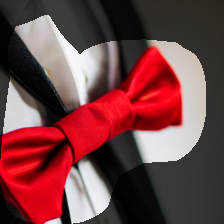

"a striped bow tie", activation: 16.7
image: 



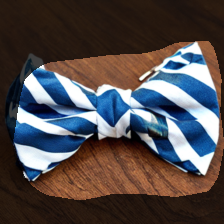

"a sequined bow tie", activation: 17.42
image: 



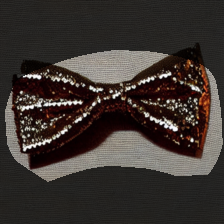



*** MAIA: ***


The updated experiments provide clear evidence that the neuron's highest activation occurs for images of people wearing bow ties, with high activations for both male and female subjects, as well as children, and regardless of the setting (professional or casual). The presence of facial hair also appears to contribute to higher activation, as seen in the image with a bearded individual wearing a bow tie. Various bow tie patterns and colors do activate the neuron to a degree, but not as strongly as when a bow tie is worn by a person.

Thus, we can confidently finalize our description and label for the neuron.

[DESCRIPTION]: The neuron is highly selective for people wearing bow ties, with a sensitivity to facial features accompanying the bow tie. The selectivity covers various contexts, individuals (male, female, child), and includes sensitivity to facial hair.

[LABEL]: people_wearing_bow_ties


In [37]:
while True:
    maia_experiment = ask_agent(maia_model,tools.experiment_log) # ask maia for the next experiment given the results log to the experiment log
    tools.update_experiment_log(role='maia', type="text", type_content=str(maia_experiment)) # update the experiment log with maia's response 
    plot_results_notebook(tools.experiment_log[-1]) # plot the result to notebook
    if "[DESCRIPTION]" in maia_experiment: break # stop the experiment if the response contains the final description. 
    maia_code = get_code(maia_experiment) # parse the code by locating Python syntax
    execute_maia_experiment(maia_code, system, tools) # execute the experiment, maia's code should contain tools.update_experiment_log(...) 
    plot_results_notebook(tools.experiment_log[-1]) # plot the result to notebook